In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fftpack
import numpy as np
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import StandardScaler
import glob
import random

In [2]:
files = glob.glob('data/*/*.CSV')

In [3]:
class well:
    
    def __init__(self, file, nperseg, label_map, state_map, num, clen, gen=False, plot=True):
        
        self.file = file
        self.name = self.file[-10:-4]
        self.nperseg = nperseg
        self.num = num
        self.clen = clen
        self.gen = gen
        self.plot = plot
        self.df = pd.read_csv(file)
        self.resample()
        self.transform()
        self.process()
        
    def process(self):
        try:
            self.label = label_map[self.name]
            self.state = state_map[label_map[self.name]]
            print(self.name + ': ' + self.label)
        except:
            print(self.name)

        if self.state != -99:
            if self.gen == True:
                self.generate_arrays()
        
    def resample(self):
        self.df.index = pd.to_datetime('2020-01-01') + pd.to_timedelta(self.df['time(sec)'], unit='s')
        self.df = self.df.resample('10L').interpolate()
        
    def transform(self, quantile=None):
        for col in self.df.columns:
            if quantile != None:
                self.df[col] = quantile_transform(
                    self.df[col].values.reshape(-1, 1),
                    n_quantiles=300,
                    output_distribution='normal',
                    copy=True
                )
            try:
                rnge = self.df[col].max() - self.df[col].min()
                self.df[col] = ((self.df[col] - self.df[col].min()) / rnge) - 0.5
            except:
                pass
        
    def spectro(self, col, df_, nperseg):
        sig = df_[col].values
        f, t, Sxx = signal.spectrogram(
            sig, 
            window='hann', 
            nperseg=nperseg, 
            noverlap=int(nperseg-1), 
            scaling='spectrum',
            mode='magnitude',
        )
#         fco = int(self.nperseg/4)+1
#         f = f[:fco]
#         Sxx = Sxx[:fco,:]
        Sxx = np.log(Sxx)
#         Sxx = quantile_transform(
#             Sxx,
#             n_quantiles=100,
#             output_distribution='normal',
#             copy=True
#         )
        Sxx = np.around(Sxx, 2)
        return t, f, Sxx

    def plot_summ(self, df_, p_, a_, l_):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))
        axes[0].set_title('card')
        axes[0].scatter(df_['pos(in)'],df_['Load_1(lbs)'], c=df_['time(sec)'])
        axes[1].set_title('pos')
        axes[1].pcolormesh(p_[0], p_[1], p_[2])
        axes[2].set_title('acceleration')
        axes[2].pcolormesh(a_[0], a_[1], a_[2])
        axes[3].set_title('load')
        axes[3].pcolormesh(l_[0], l_[1], l_[2])
        try:
            title = self.file + ' ' + self.label
        except:
            title = self.file
        fig.suptitle(title)
        plt.show()

    def generate_arrays(self):
        xmax = len(self.df)-self.clen
        for i in range(self.num):
            start = random.randint(0,xmax)
            end = start+self.clen
            
            df_ = self.df[start:end]
            p_ = self.spectro('pos(in)', df_, self.nperseg)
            a_ = self.spectro('acc(in/s/s)', df_, self.nperseg)
            l_ = self.spectro('Load_1(lbs)', df_, self.nperseg)
            input_ = np.dstack((p_[2].T,a_[2].T,l_[2].T))
            output_ = np.array(self.state)
            
            np.savez_compressed('arrays/'+self.name+'_'+str(i), X=input_, y=output_)
            df_.to_csv('cards/'+self.name+'_'+str(i)+'.csv', index=False)
            
            if self.plot == True:
                self.plot_summ(df_, p_, a_, l_)

In [4]:
state_map = {
    'nan':-99,
    'normal':0,
    'fluid_pound':1,
    'standing_valve':2,
    'sticking':3,
    'barrel_leak':4,
    'gas':5,
    'bad_data':6,
}

label_map = {
    '5X5E03':'normal',
    '4X5E03':'normal',
    '2X5F06':'nan',
    '3X5F06':'nan',
    '2X5F03':'standing_valve',
    '3X5F03':'sticking',
    '5X5E06':'nan',
    '4X5E06':'nan',
    '4X5F03':'sticking',
    '2X5E06':'nan',
    '3X5E06':'nan',
    '2X5E03':'normal',
    '3X5E03':'normal',
    '5X5F06':'nan',
    '4X5F06':'nan',
    '5X5F03':'nan',
    '1X5F03':'bad_data',
    '1X5F06':'nan',
    '1X5E03':'bad_data',
    '1X5F06':'nan',
    '1X5E03':'bad_data',
    '1X5E06':'nan',
    '5X6H03':'normal',
    '4X6H03':'normal',
    '3X6I06':'nan',
    '1X6D03':'bad_data',
    '1X6F03':'bad_data',
    '3X6I03':'normal',
    '1X6E06':'nan',
    '1X6C03':'bad_data',
    '5X6I03':'normal',
    '4X6I03':'normal',
    '3X6H03':'normal',
    '5X6I06':'nan',
    '4X6I06':'nan',
    '1X6E03':'bad_data',
    '4X6C03':'normal',
    '5X6C03':'normal',
    '3X6F03':'normal',
    '1X6I03':'bad_data',
    '4X6E06':'nan',
    '5X6E06':'nan',
    '3X6D03':'normal',
    '4X6E03':'normal',
    '5X6E03':'normal',
    '1X6I06':'nan',
    '3X6E03':'normal',
    '1X6H03':'bad_data',
    '3X6C03':'normal',
    '4X6F03':'normal',
    '5X6F03':'normal',
    '3X6E06':'nan',
    '4X6D03':'normal',
    '5X6D03':'normal',
    '3X1C07':'normal',
    '2X1C13':'fluid_pound',
    '2X1C07':'normal',
    '3X1C13':'fluid_pound',
    '3X1C17':'normal',
    '2X1C17':'normal',
    '3X1C02':'normal',
    '2X1C02':'normal',
    '4X1C17':'normal',
    '5X1C17':'normal',
    '4X1C02':'normal',
    '5X1C02':'normal',
    '4X1C07':'normal',
    '5X1C13':'fluid_pound',
    '5X1C07':'normal',
    '4X1C13':'fluid_pound',
    '4X1C24':'normal',
    '5X1C24':'normal',
    '3X1C24':'normal',
    '2X1C24':'normal',
    '5X5G03':'normal',
    '4X5G03':'normal',
    '5X5G06':'nan',
    '4X5G06':'nan',
    '2X5G06':'nan',
    '3X5G06':'nan',
    '2X5G03':'normal',
    '3X5G03':'normal',
    '5X5J06':'nan',
    '3X5I03':'gas',
    '2X5I03':'gas',
    '4X5H06':'nan',
    '5X5H06':'nan',
    '3X5I06':'nan',
    '2X5I06':'nan',
    '4X5H03':'normal',
    '5X5H03':'normal',
    '5X5J03':'normal',
    '5X5I06':'nan',
    '3X5H03':'fluid_pound',
    '2X5H03':'gas',
    '3X5J03':'gas',
    '2X5J03':'gas',
    '3X5J06':'nan',
    '2X5J06':'nan',
    '5X5I03':'normal',
    '3X5H06':'nan',
    '2X5H06':'nan',
    '1X4D14':'nan',
    '2X4C08':'fluid_pound',
    '3X4C08':'fluid_pound',
    '1X4D17':'nan',
    '5X4D08':'fluid_pound',
    '4X4D08':'normal',
    '1X4D02':'nan',
    '1X4D05':'bad_data',
    '1X4D11':'bad_data',
    '1X4C05':'bad_data',
    '1X4C11':'bad_data',
    '5X4C08':'gas',
    '4X4C08':'gas',
    '1X4C02':'nan',
    '1X4C14':'nan',
    '2X4D08':'normal',
    '3X4D08':'normal',
    '2X4D05':'fluid_pound',
    '3X4D11':'fluid_pound',
    '3X4D05':'fluid_pound',
    '2X4D11':'fluid_pound',
    '4X4C11':'fluid_pound',
    '5X4C05':'bad_data',
    '5X4C11':'normal',
    '4X4C05':'bad_data',
    '2X4D17':'nan',
    '4X4C14':'nan',
    '5X4C14':'nan',
    '5X4D05':'fluid_pound',
    '4X4D11':'fluid_pound',
    '4X4D05':'fluid_pound',
    '5X4D11':'fluid_pound',
    '3X4C11':'normal',
    '2X4C05':'normal',
    '2X4C11':'normal',
    '3X4C05':'normal',
    '2X3C14':'normal',
    '3X3C02':'normal',
    '2X3C02':'normal',
    '4X3D05':'normal',
    '5X3D05':'normal',
    '2X3C11':'normal',
    '3X3C11':'normal',
    '3X3D05':'normal',
    '2X3D05':'normal',
    '5X3C11':'normal',
    '4X3C11':'normal',
    '5X3C14':'normal',
    '4X3C14':'normal',
    '4X3C02':'normal',
    '5X3C02':'normal',
    '1X3C08':'barrel_leak',
    '1X3C11':'barrel_leak',
    '4X3C08':'normal',
    '5X3C08':'normal',
    '1X3C02':'barrel_leak',
    '1X3C14':'barrel_leak',
    '3X3D08':'normal',
    '2X3D08':'normal',
    '3X3C08':'normal',
    '2X3C08':'normal',
    '4X3D08':'normal',
    '5X3D08':'normal',
    '1X3D05':'barrel_leak',
    '1X2D02':'bad_data',
    '5X2D02':'normal',
    '4X2D02':'normal',
    '2X2D02':'standing_valve',
    '3X4D17':'nan',
    '2X4D02':'nan',
    '3X4D02':'nan',
    '3X4D14':'nan',
    '2X4D14':'nan',
    '5X4C02':'nan',
    '4X4C02':'nan',
    '1X4C08':'bad_data',
    '3X4C14':'nan',
    '2X4C14':'nan',
    '5X4D17':'nan',
    '4X4D17':'nan',
    '5X4D02':'nan',
    '4X4D02':'nan',
    '1X4D08':'bad_data',
    '4X4D14':'nan',
    '5X4D14':'nan',
    '2X4C02':'nan',
    '3X4C02':'nan',
    '4X3D02':'nan',
    '5X3D02':'nan',
    '1X3D08':'barrel_leak',
    '3X3C17':'nan',
    '2X3C17':'nan',
    '5X3D11':'nan',
    '4X3D11':'nan',
    '3X3C05':'nan',
    '2X3C05':'nan',
    '2X3D11':'nan',
    '3X3D11':'nan',
    '4X3C05':'nan',
    '5X3C05':'nan',
    '3X3D02':'nan',
    '2X3D02':'nan',
    '4X3C17':'nan',
    '5X3C17':'nan',
    '1X3C05':'nan',
    '1X3C17':'nan',
    '1X3D02':'nan',
    '1X3D11':'nan',
    '2/TEMP':'nan',
}

3X5F03: sticking


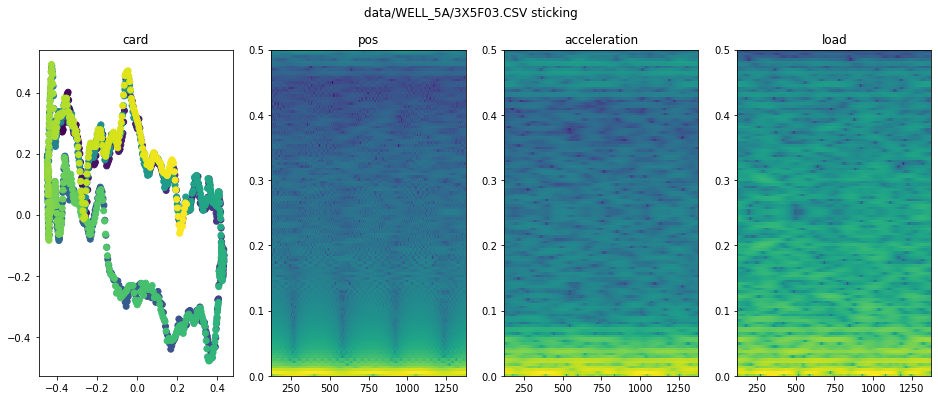

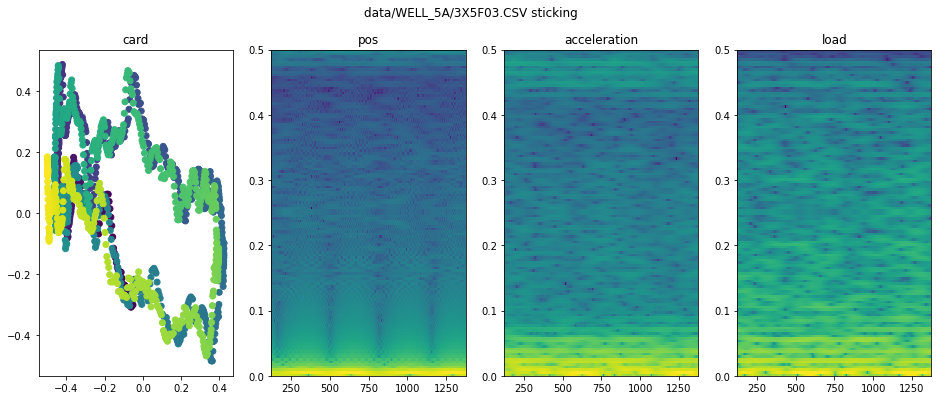

In [5]:
test = well(files[5], nperseg=250, label_map=label_map, state_map=state_map, num=2, clen=1500, gen=True, plot=True)

In [6]:
for file in files:
    try:
        _ = well(file, nperseg=250, label_map=label_map, state_map=state_map, num=20, clen=1500, gen=True, plot=False)
    except:
        pass

5X5E03: normal
4X5E03: normal
2X5F06: nan
2X5F03: standing_valve
3X5F03: sticking
5X5E06: nan
4X5E06: nan
5X5F03: nan
4X5F03: sticking
2X5E06: nan
3X5E06: nan
2X5E03: normal
3X5E03: normal
5X5F06: nan
4X5F06: nan
1X5F03: bad_data
1X5F06: nan
1X5E03: bad_data
1X5E06: nan
5X6H03: normal
4X6H03: normal
3X6I06: nan
1X6D03: bad_data
1X6F03: bad_data
3X6I03: normal
1X6E06: nan
1X6C03: bad_data
5X6I03: normal
4X6I03: normal
3X6H03: normal
5X6I06: nan
4X6I06: nan
1X6E03: bad_data
4X6C03: normal
5X6C03: normal
3X6F03: normal
1X6I03: bad_data
4X6E06: nan
5X6E06: nan
3X6D03: normal
4X6E03: normal
5X6E03: normal
1X6I06: nan
3X6E03: normal
1X6H03: bad_data
3X6C03: normal
4X6F03: normal
5X6F03: normal
3X6E06: nan
4X6D03: normal
5X6D03: normal
3X1C07: normal
2X1C13: fluid_pound
2X1C07: normal
3X1C13: fluid_pound
3X1C17: normal
2X1C17: normal
3X1C02: normal
2X1C02: normal
4X1C17: normal
5X1C17: normal
4X1C02: normal
5X1C02: normal
4X1C07: normal
5X1C13: fluid_pound
5X1C07: normal
4X1C13: fluid_pound
4